#### Importing packages

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import scipy
from scipy import sparse,  io, linalg
import pickle
from tqdm import tqdm_notebook as tqdm
import networkx as nx

### Importing Committee to Candidate donations
Format: CommitteeID, CandidateID, Time, Amount

What the candidate receives.

I think this is the inweight they talk about in [8]

In [18]:
#Com2Cand = np.loadtxt('/Users/vaishnan/Documents/15826/campaign-contribution-text/Com2Cand.txt',int)

### Importing Donor to Committee donations
Format: CommitteeID, DonorID, Time, Amount

What the donor organization donates.

I think is the the out-weight they talk about in [8]

In [19]:
#Don2Com = np.loadtxt('/Users/vaishnan/Documents/15826/campaign-contribution-text/Don2Com.txt',int)

The max id for each object. 

In [2]:
NumCandidates = 61618
NumCommittees = 60063
NumDonors = 6368912

#### Converting the year columns to just years

In [21]:
#Com2Cand[:,2]/=10000
#Don2Com[:,2]/=10000
#np.save('/Users/vaishnan/Documents/15826/campaign-contribution-text/Com2Cand.data', Com2Cand)
#np.save('/Users/vaishnan/Documents/15826/campaign-contribution-text/Don2Com.data',Don2Com)

In [2]:
Com2Cand  = np.load('/Users/vaishnan/Documents/15826/campaign-contribution-text/Com2Cand.data.npy')
Don2Com = np.load('/Users/vaishnan/Documents/15826/campaign-contribution-text/Don2Com.data.npy')

#### Select only records corresponding to 2006

In [3]:
def get_records_of_year(records, year):
    selected_rows = (records[np.array([idx for idx in range(records.shape[0]) if records[idx, 2] == year]),:])
    return selected_rows[:,np.array([0,1,3])]
    # Removes year


Com2CandFinal = get_records_of_year(Com2Cand, 2006)
Don2ComFinal = get_records_of_year(Don2Com, 2006)



In [5]:
def digraph_from_array(records):
    G = nx.DiGraph()
    for i in tqdm(range(records.shape[0])):
        if G.has_edge(records[i,0],records[i,1]):
            G[records[i,0]][records[i,1]]['weight']+=records[i,2]
        else:
            G.add_edge(records[i,0],records[i,1],weight=records[i,2])


#### Get outdegree and outweights

In [5]:
def get_degree_and_weight(records, max_index):
    # Second column is what we want to be summarized over
    summary = np.zeros((max_index+1, 2))
    # Each row is a (degree, weight)
    for i in range(records.shape[0]):
        nodeId = records[i,1]
        summary[nodeId,0] += 1
        summary[nodeId,1] += records[i,2]
    return summary

outweights = get_degree_and_weight(Don2ComFinal, NumDonors)
inweights = get_degree_and_weight(Com2CandFinal, NumCandidates)


In [119]:
min(Don2ComFinal[:,2]) # Why do I see negative contributions?

-96480

### Log Log Plots for outweights and inweights

In [6]:
def plot_log_log(records):
    fig, ax = plt.subplots()
    # Remove zero values
    records = records[np.array([idx for idx in range(records.shape[0]) if records[idx, 0]>0 and records[idx,1] > 0]),:]
    #median_x, median_y = zip(*sorted((xVal, np.median([yVal for a, yVal in zip(records[:,0], records[:,1]) if xVal==a])) for xVal in set(records[:,0])))
    plt.scatter([np.log(r) for r in records[:,0]], [np.log(r) for r in  records[:,1]],s=0.5)
    # Todo add median code
    
    
def plot_log_log_median(records,B=20):
    fig, ax = plt.subplots()
    records = records[np.array([idx for idx in range(records.shape[0]) if records[idx, 0]>0 and records[idx,1] > 0]),:]
    xs = [np.log(record[0]) for record in records]
    ys = [np.log(record[1]) for record in records]
    x_max = max(xs)
    # bin into default 20 values
    binned_xs = [x_max*i/float(B) for i in range(B+1)]
    median_ys = []
    err = []
    for i in range(B):
        # find median y values for x values in [binned_xs[i], binned_xs[i+1])
        current_ys = [ys[j] for j in range(len(xs)) if binned_xs[i] <= xs[j] and xs[j] < binned_xs[i+1]]
        current_y = np.median(current_ys)
        median_ys += [current_y]
        #err += [[median_ys-np.std(current_ys)*0.5,median_ys+np.std(current_ys)*0.5]]
        err += [np.std(current_ys)]



    plt.errorbar(binned_xs[1:], median_ys, marker='o', yerr=err)



<IPython.core.display.Javascript object>


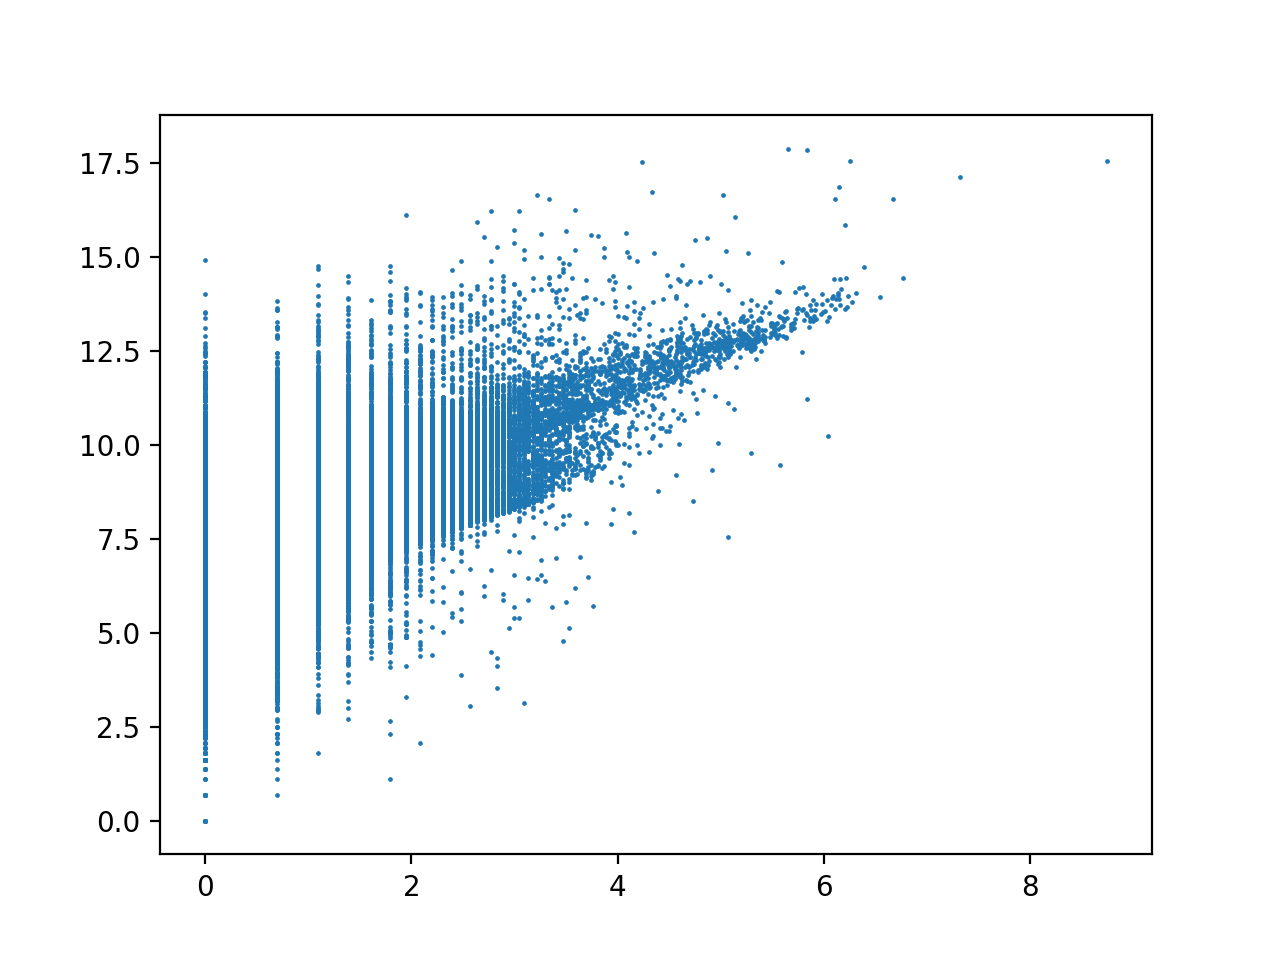

In [136]:
plot_log_log(outweights)

<IPython.core.display.Javascript object>


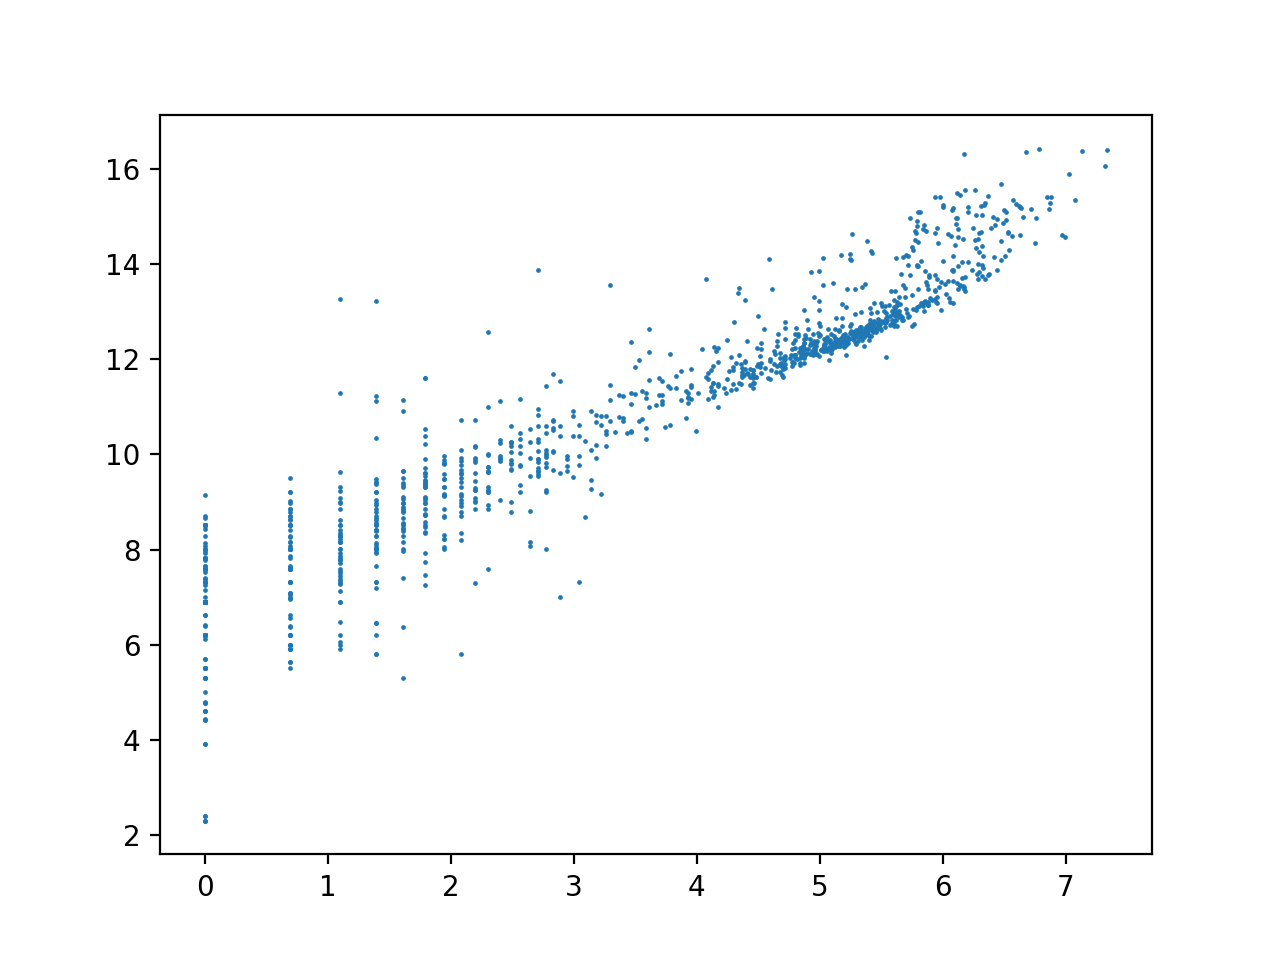

In [135]:
plot_log_log(inweights)

<IPython.core.display.Javascript object>


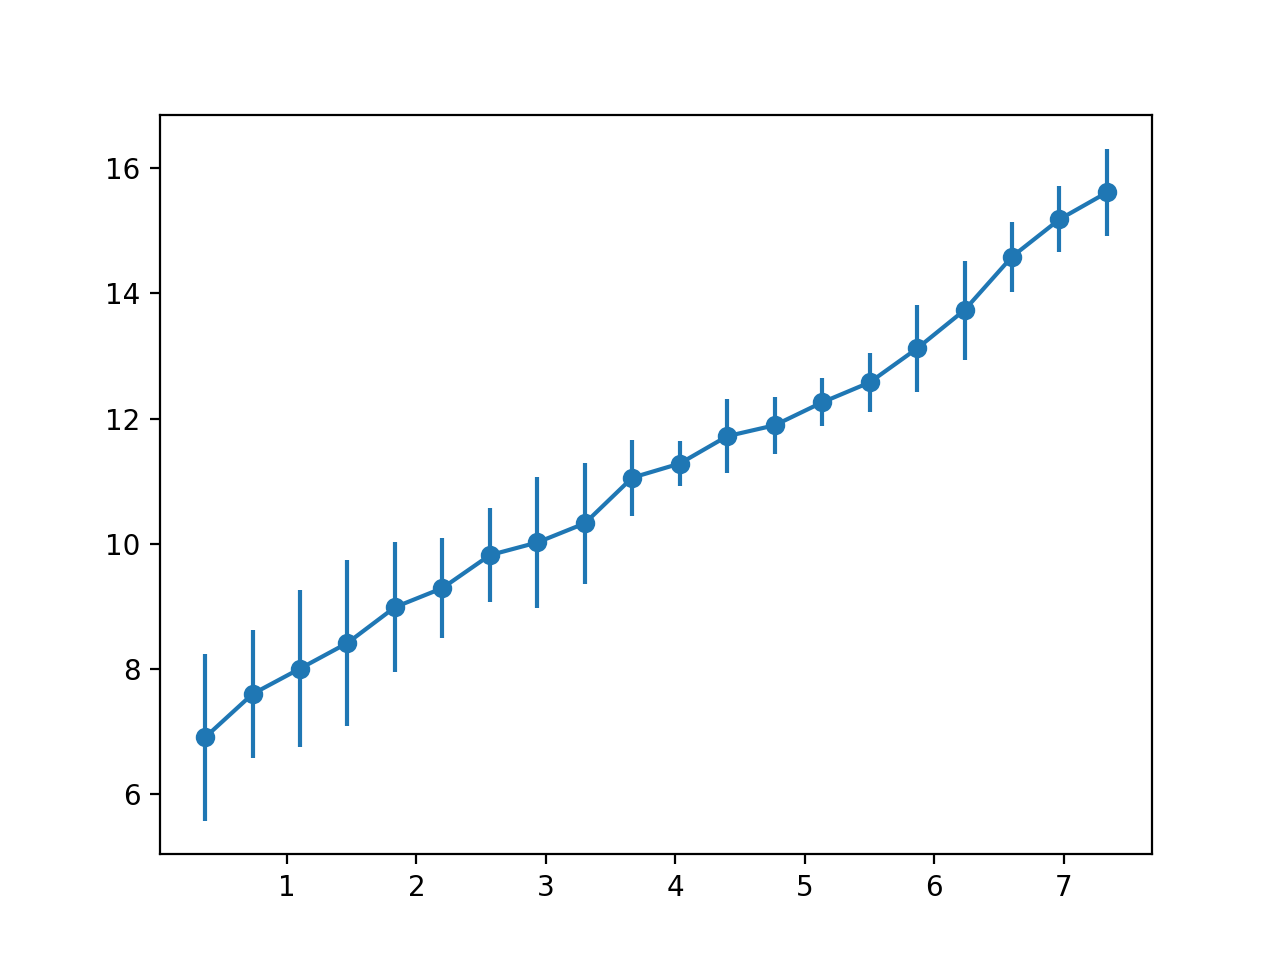

In [235]:
plot_log_log_median(inweights,B=20)

### Edge weight power law

In [8]:
def get_edge_weights(records):
    # For each existing edge in the record, merges duplicates by adding them up
    edge_weights = {}
    for i in range(records.shape[0]):
        # Add newly found weight
        edge_weights[(records[i,0], records[i,1])] = edge_weights.get((records[i,0], records[i,1]), 0) + records[i,2]
    return edge_weights

def get_ewpl(records, edge_weights, maxIndex):
    # Records is either Don2Com or Com2Cand
    # First get (the degree and) incident weight data on each candidate/donor
    # Summary of column 1
    node_summary = get_degree_and_weight(records, maxIndex)
    # Get (the degree and) incident weight data on each committee
    # I swap the first two columns in the record to do this
    # Summary of column 0 
    comm_summary = get_degree_and_weight(records[:,np.array([1,0,2])], NumCommittees)
    # Now we need to generate a list of ordered pairs of the
    # form(edge-weight, sqrt(weights incident on end points)) 
    # But before that we need to merge records corresponding to same (i,j)
    # Each edge is (committee, candidate)
    #edge_weights = get_edge_weights(records)
    # Update: This should be passed

    x = []
    y = []
    #results = np.zeros((len(edge_weights.keys()),2))
    for edge in edge_weights.keys():
        # Add edge weight as x value
        #edge = edge_weights.keys()[i]
        val = edge_weights[edge]
        x += [edge_weights[edge]]
        # Add product of incident weights
        y += [(node_summary[edge[1],1]-val)*(comm_summary[edge[0],1]-val)]
        #results[i,1] = (cand_summary[edge[1],1]-val)*(comm_summary[edge[0],1]-val)
        #results[i,0] = val
    return np.asarray(zip(x,y))

In [9]:
Don2ComFinal_ew = get_edge_weights(Don2ComFinal)
Com2CandFinal_ew = get_edge_weights(Com2CandFinal)
# Actuall this is quite fast :)

In [58]:
#pickle.dump(Com2CandFinal_ew, open('/Users/vaishnan/Documents/15826/campaign-contribution-text/Com2CandFinal_ew.p','wb'))
#pickle.dump(Don2ComFinal_ew, open('/Users/vaishnan/Documents/15826/campaign-contribution-text/Don2ComFinal_ew.p','wb'))

In [59]:
#Com2CandFinal_ew= pickle.load(open('/Users/vaishnan/Documents/15826/campaign-contribution-text/Com2CandFinal_ew.p','rb'))
#Don2ComFinal_ew=pickle.dump(open('/Users/vaishnan/Documents/15826/campaign-contribution-text/Don2ComFinal_ew.p','rb'))

In [ ]:
#Com2CandFinal_ew=pickle.load(open('/Users/vaishnan/Documents/15826/campaign-contribution-text/Com2CandFinal_ew.p','rb'))
#Don2ComFinal_ew=pickle.load(open('/Users/vaishnan/Documents/15826/campaign-contribution-text/Don2ComFinal_ew.p','rb'))

In [183]:
Don2Com_ewpl = get_ewpl(Don2ComFinal, Don2ComFinal_ew, NumDonors)

<IPython.core.display.Javascript object>


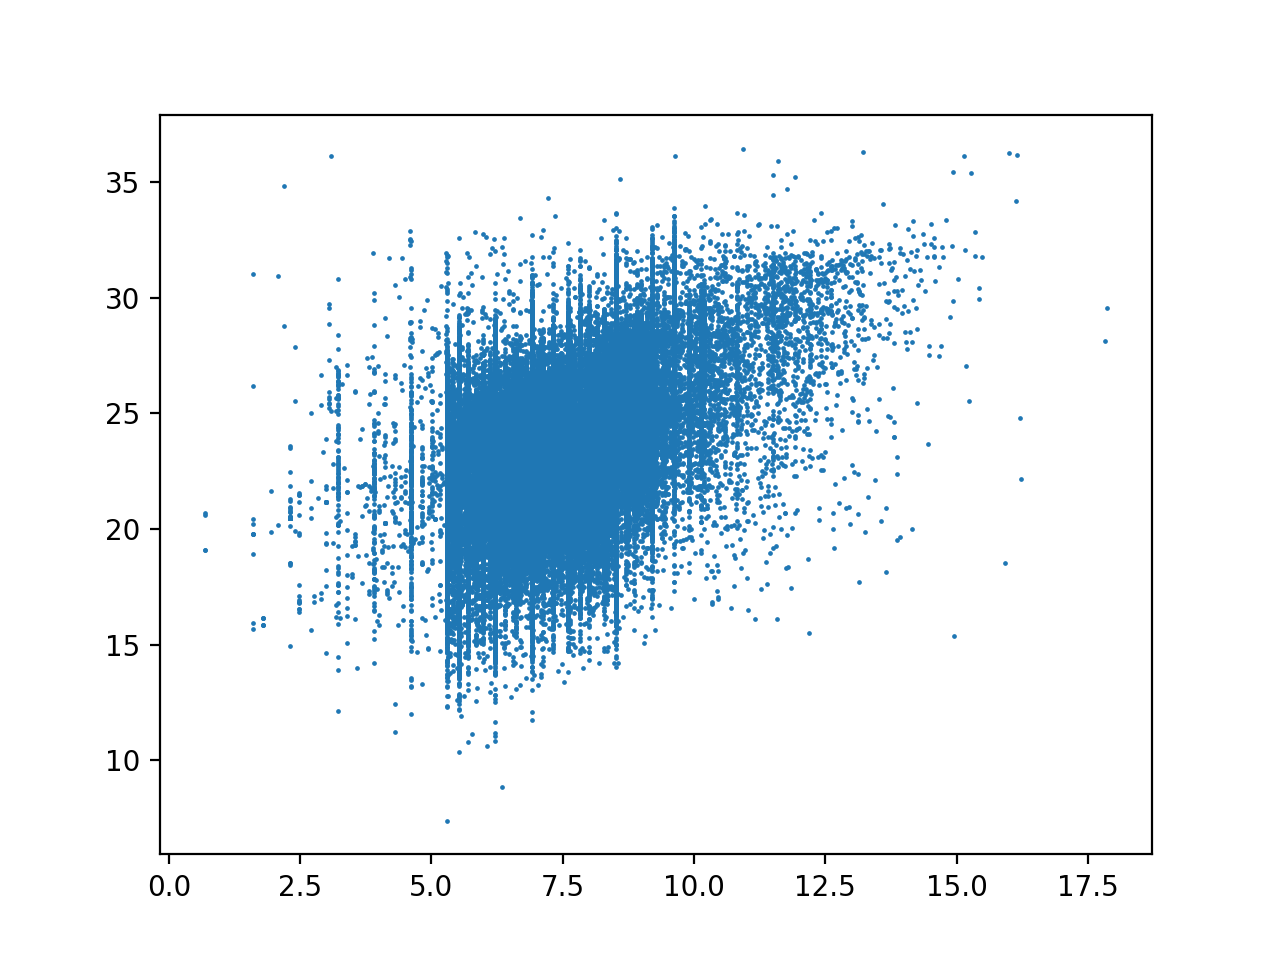

In [186]:
plot_log_log(Don2Com_ewpl)

## Edge weight vs Mutual neighbors

In [11]:
def get_neighborhood(records):
    # each key is a node in column 1 and each value is a set nodes from column 0
    nbrs = {}
    for i in tqdm(range(records.shape[0])):
        nbrs[records[i,1]]=nbrs.get(records[i,1],set()).union(set([records[i,0]]))
    return nbrs

def get_mutual(nbr_1, nbr_2, i, j):
    # Find nbr2 of nbr 1 of j and nbr2 of j
    result = set()
    for j_prime in nbr_1.get(i,set()):
        result = result.union(nbr_2.get(j_prime, set()))
    return len(result.intersection(nbr_2.get(j,set())))


def get_inv_edge_weights(records):
    # For each existing edge in the record, merges duplicates by adding them up
    inv_edge_weights = {}
    for i in tqdm(range(records.shape[0])):
        # Add newly found weight
        inv_edge_weights[records[i,2]] = inv_edge_weights.get(records[i,2], []) + [(records[i,0], records[i,1])]
    return inv_edge_weights


def ew_mutual(records, maxIndex, node_neighbors = None, comm_neighbors = None, sample_size=None):
    # each key is a node/comm and each value is a set of comm/nodes
    # Because of speed I'll save these
    if node_neighbors == None:
        node_neighbors = get_neighborhood(records)
    if comm_neighbors == None:
        comm_neighbors = get_neighborhood(records[:,np.array([1,0])])
    edge_weights =  get_edge_weights(records)
    x = []
    y = []
    edges=edge_weights.keys()
    if sample_size == None:
        random_idx = range(len(edges))
    else:
        random_idx = np.random.choice(xrange(len(edges)),replace=False,size=sample_size)
    #random_edges = np.random.choice(edge_weights.keys(),replace=False,size=sample_size) 
    for i in tqdm(random_idx):
        # Add edge weight as x value
        #edge = edge_weights.keys()[i]
        edge = edges[i]
        val = edge_weights[edge]
        x += [edge_weights[edge]]
        # Add product of incident weights
        y += [get_mutual(node_neighbors, comm_neighbors, edge[1], edge[0])*get_mutual(comm_neighbors, node_neighbors, edge[0], edge[1])]
    return np.asarray(zip(x,y))



In [212]:
#donor_comm_neighbors = get_neighborhood(records) #donor's neighbors
#comm_donor_neighbors = get_neighborhood(records[:,np.array([1,0])]) #committee's neighbors
Don2ComFinal_inv_ew = get_inv_edge_weights(Don2ComFinal)

KeyboardInterrupt: 

In [66]:
#pickle.dump(donor_comm_neighbors, file=open('/Users/vaishnan/Documents/15826/campaign-contribution-text/donor_comm_neighbors.p','wb'))
#pickle.dump(comm_donor_neighbors, file=open('/Users/vaishnan/Documents/15826/campaign-contribution-text/comm_donor_neighbors.p', 'wb'))

In [13]:
node_neighbors=pickle.load(file=open('/Users/vaishnan/Documents/15826/campaign-contribution-text/donor_comm_neighbors.p','rb'))
comm_neighbors=pickle.load(file=open('/Users/vaishnan/Documents/15826/campaign-contribution-text/comm_donor_neighbors.p', 'rb'))

In [187]:
Don2ComFinal_ewm=ew_mutual(Don2ComFinal, NumDonors, donor_comm_neighbors, comm_donor_neighbors,sample_size=10000)

In [177]:

min([x for x in Don2ComFinal_ew.values() if x > 10000])

10005

<IPython.core.display.Javascript object>


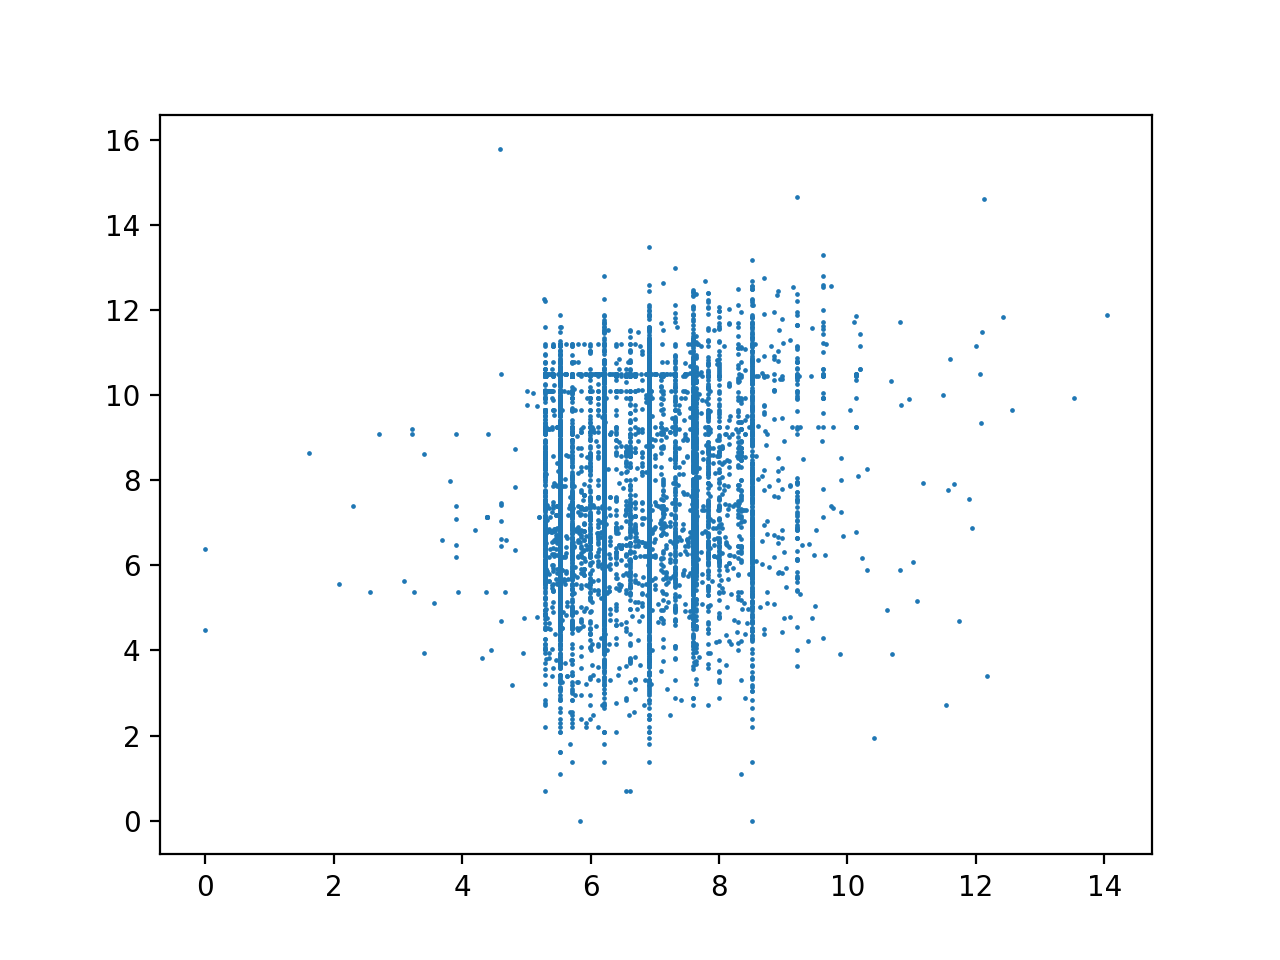

In [188]:
plot_log_log(Don2ComFinal_ewm) # Seems hopeful...

<IPython.core.display.Javascript object>


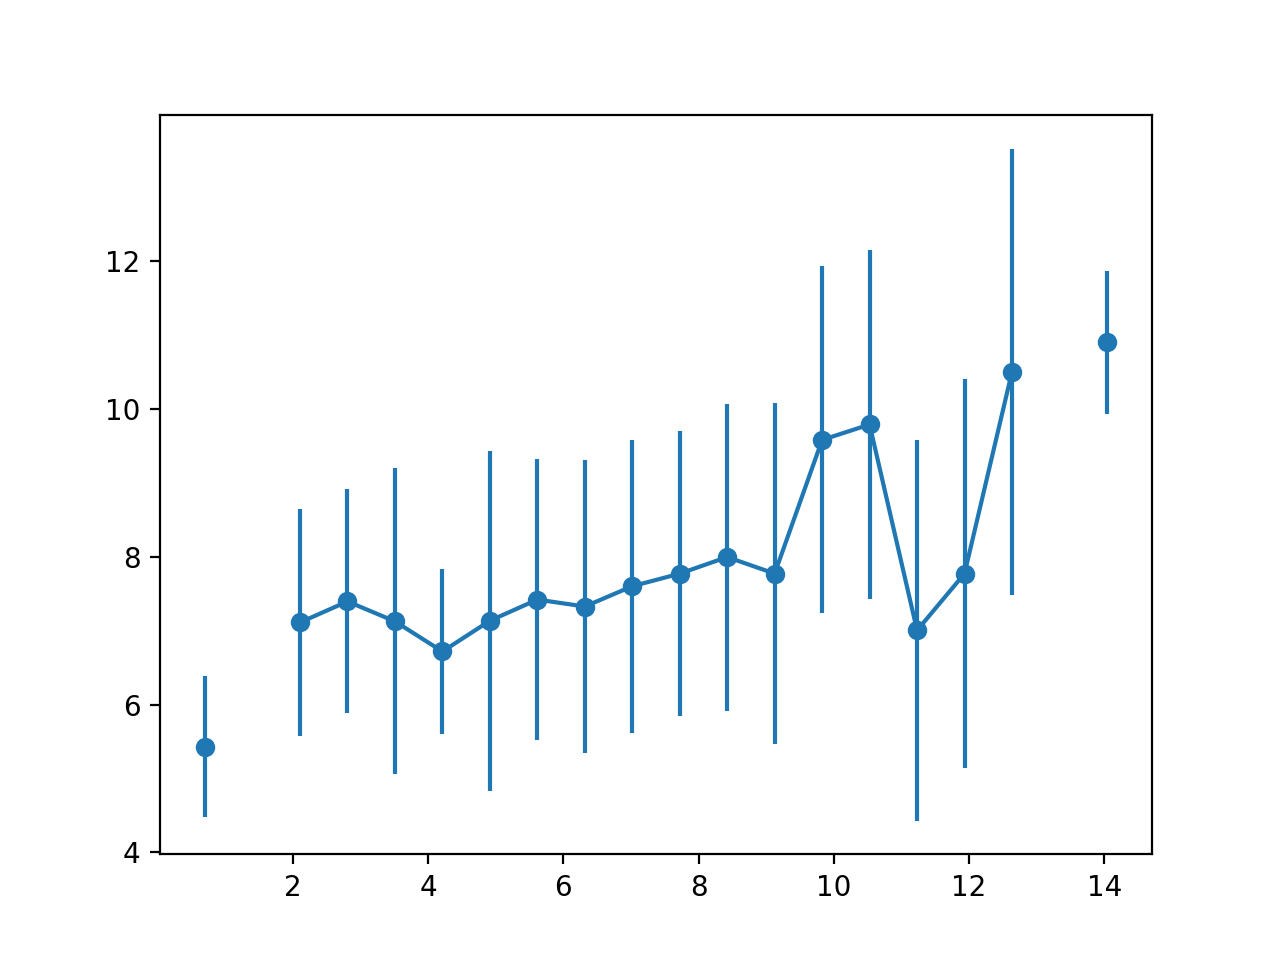

In [189]:
### Edge Weight and Node-Node similarity
plot_log_log_median(Don2ComFinal_ewm) 

## Self-similarity

In [10]:
#def self_similarity(records):
records = Don2ComFinal
# First create scipy adjacency matrix
maxNodeIndex = NumDonors
maxCommIndex = NumCommittees
edge_weights =  Don2ComFinal_ew
col_idx, row_idx = zip(*edge_weights.keys())
data=edge_weights.values()
#adjacency = sparse.bsr_matrix((maxCommIndex, maxNodeIndex))
#for edge in edge_weights.keys():
#    adjacency[edge[0], edge[1]] = edge_weights[edge]
adjacency = sparse.csc_matrix((data,(row_idx, col_idx)), shape=(maxNodeIndex+1,maxCommIndex+1))
# Donor x Comm matrix

    

In [102]:
# Select only log n random columns
random_comm = np.random.choice(range(NumCommittees),replace=False,size=int(4000*np.log(NumCommittees)))

In [103]:
#sq_adjacency = sparse.csr_matrix.transpose(adjacency)*adjacency
# Donor x Donor matrix
projected_adjacency = sparse.csr_matrix(adjacency[:,random_comm])

In [104]:
print(projected_adjacency.shape)
print(adjacency.shape)

(6368913, 44012)
(6368913, 60064)


In [165]:
Don2Com_bc = box_counting(projected_adjacency, sample_size=200)


89.0
11530.8282443
11.2605744573


In [156]:
np.log(Don2Com_bc[0:20])

array([[  9.40563561,  10.59663473],
       [  9.23234881,  10.59663473],
       [  9.05906202,  10.59663473],
       [  8.88577522,  10.59663473],
       [  8.71248843,  10.59154681],
       [  8.53920163,  10.58655914],
       [  8.36591484,  10.5815211 ],
       [  8.19262804,  10.5815211 ],
       [  8.01934125,  10.5815211 ],
       [  7.84605445,  10.58144495],
       [  7.67276766,  10.58114031],
       [  7.49948086,  10.56098165],
       [  7.32619407,  10.56061888],
       [  7.15290727,  10.5557867 ],
       [  6.97962048,  10.55025042],
       [  6.80633368,  10.5249776 ],
       [  6.63304689,  10.5249776 ],
       [  6.45976009,  10.52478958],
       [  6.2864733 ,  10.52414468],
       [  6.1131865 ,  10.49824983]])

## Box Counting

In [164]:
#numpy.linalg.norm(a-b)
def box_counting(records,sample_size=1000):
    # each row is a point in some dimension
    distances = []
    sample_i = np.random.randint(records.shape[0],size=sample_size)
    sample_j = np.random.randint(records.shape[0],size=sample_size)
    #samples= zip(sample_i,sample_j)

    for i in tqdm(sample_i):
        for j in sample_j:
            distances += [sparse.linalg.norm(records[i,:]-records[j,:])]
    r = max(distances)*2
    print(min([v for v in distances if v>0]))
    print(r)
    M=80
    xs = []
    ys = []
    for i in xrange(M):
        r = r/pow(2.0,0.125)
        distances = [d for d in distances if d <= r]
        xs += [r]
        ys += [len(distances)]
    print(r)
    return np.asarray(zip(xs,ys))

<IPython.core.display.Javascript object>


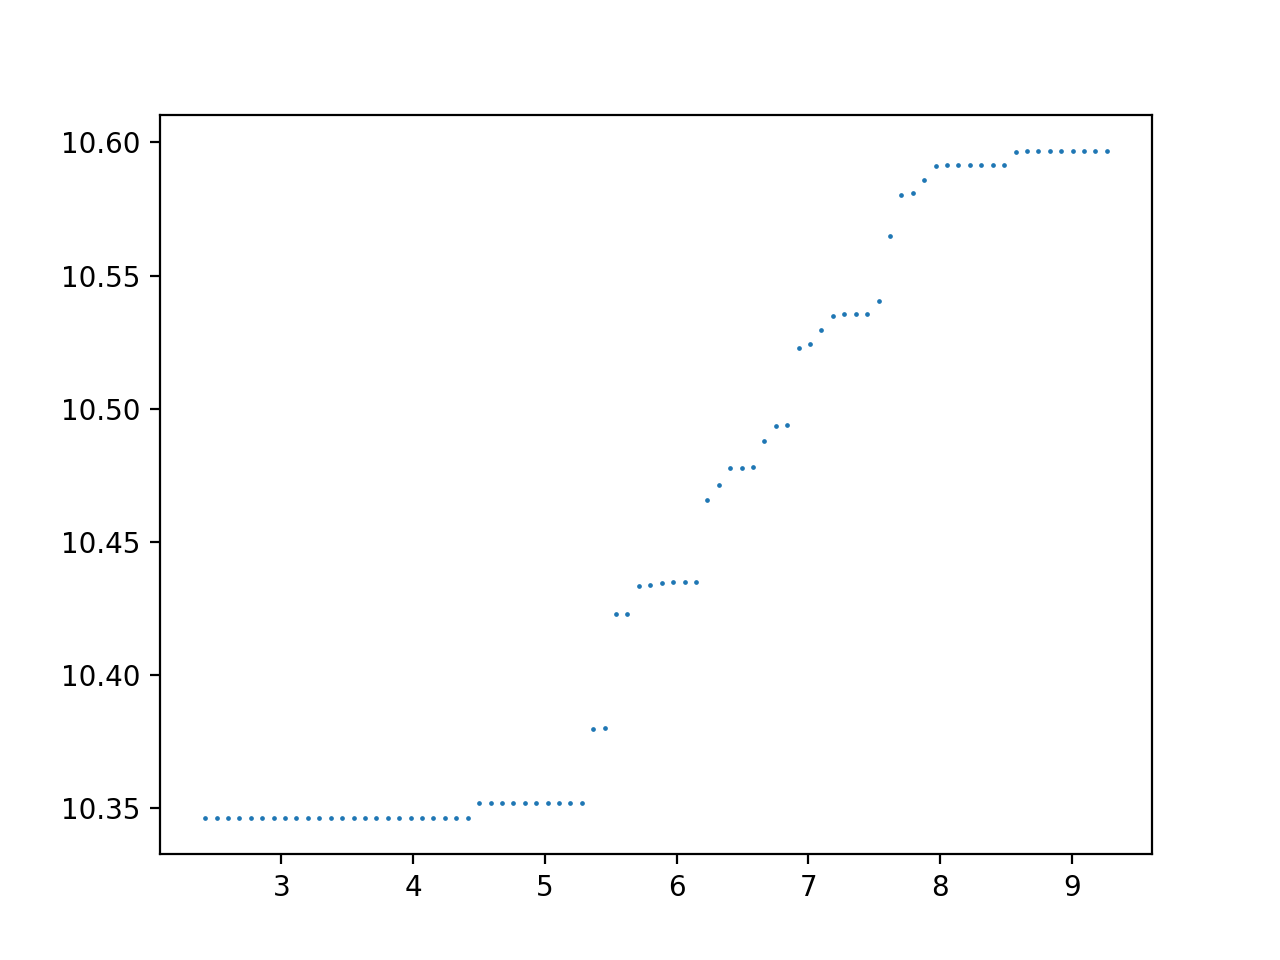

In [167]:
plot_log_log(Don2Com_bc)

In [219]:
transposed_adjacency = sparse.csc_matrix((data,(col_idx,row_idx)), shape=(maxCommIndex+1,maxNodeIndex+1))

In [221]:
random_comm = np.random.choice(range(NumDonors),replace=False,size=int(4000*np.log(NumDonors)))
projected_transposed_adjacency = sparse.csr_matrix(transposed_adjacency[:,random_comm])

In [222]:
Don2Com_bc_rev = box_counting(projected_transposed_adjacency, sample_size=100)


500.0
6356.88603013
6.20789651379


<IPython.core.display.Javascript object>


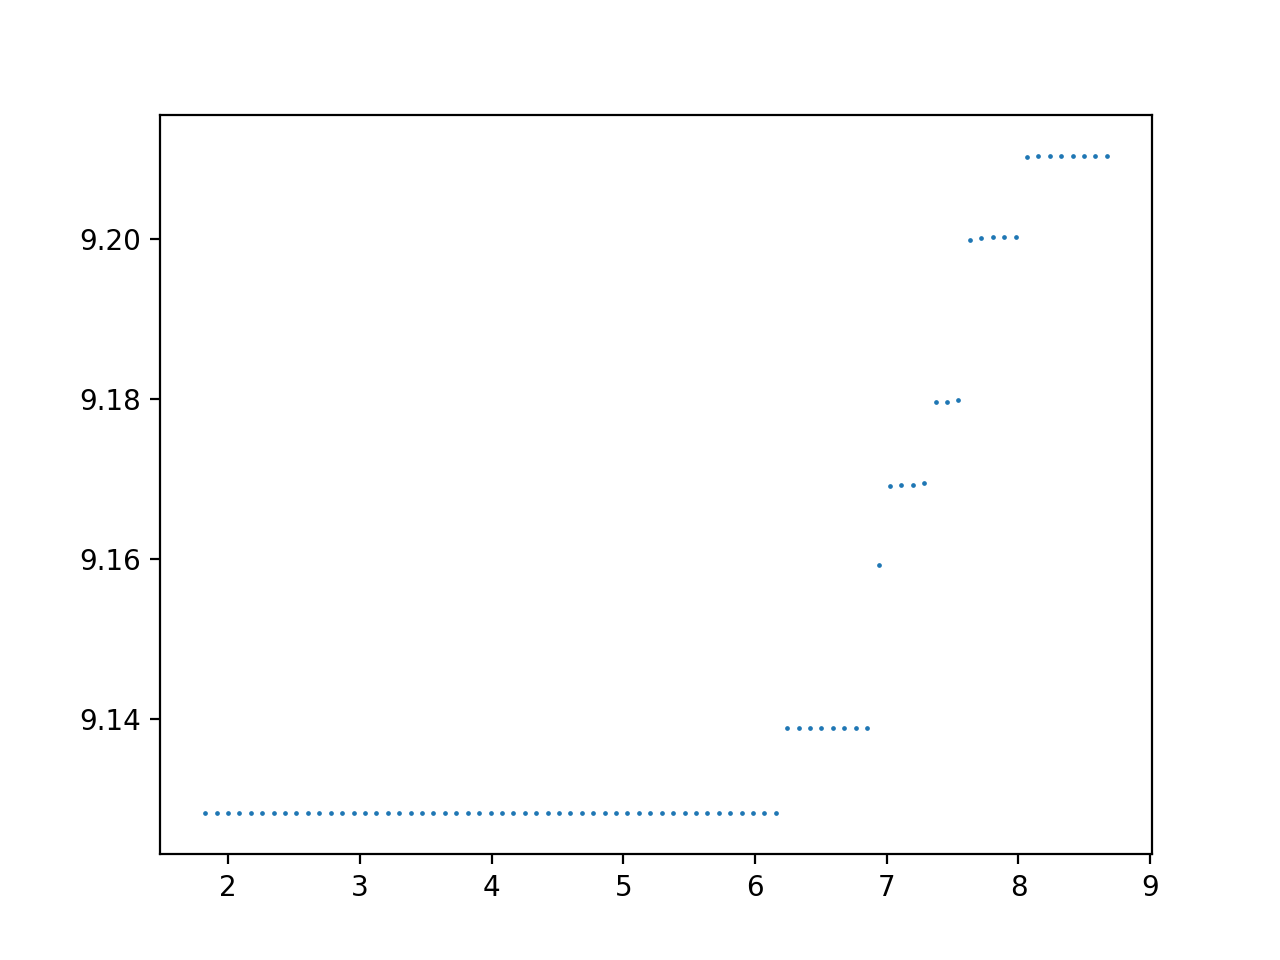

In [223]:
plot_log_log(Don2Com_bc_rev)

In [193]:
len([idx for idx in range(inweights.shape[0]) if inweights[idx,0] == 0])

60307

In [197]:
inweights.shape[0]

61619

### Random Cluster Based Self-similarity

In [ ]:
def get_growth(records, sample_size=100):
    # picks 100 points in column 2 
    

In [14]:
records = Don2ComFinal
node_neighbors = get_neighborhood(records)
comm_neighbors = get_neighborhood(records[:,np.array([1,0])])



NameError: name 'sample_size' is not defined

In [36]:

for i in tqdm(xrange(10)):
    # For each node that is to be added, add neighboring committees
    new_comm = set()
    for node in new_nodes:
        new_comm.update(node_neighbors[node])
    new_nodes = set()
    for comm in new_comm:
        new_nodes.update(comm_neighbors[comm])
    seen_nodes.update(new_nodes)    
    xs += [(i+1)]
    ys += [len(seen_nodes)]
    #return np.asarray(zip(xs,ys))



<IPython.core.display.Javascript object>


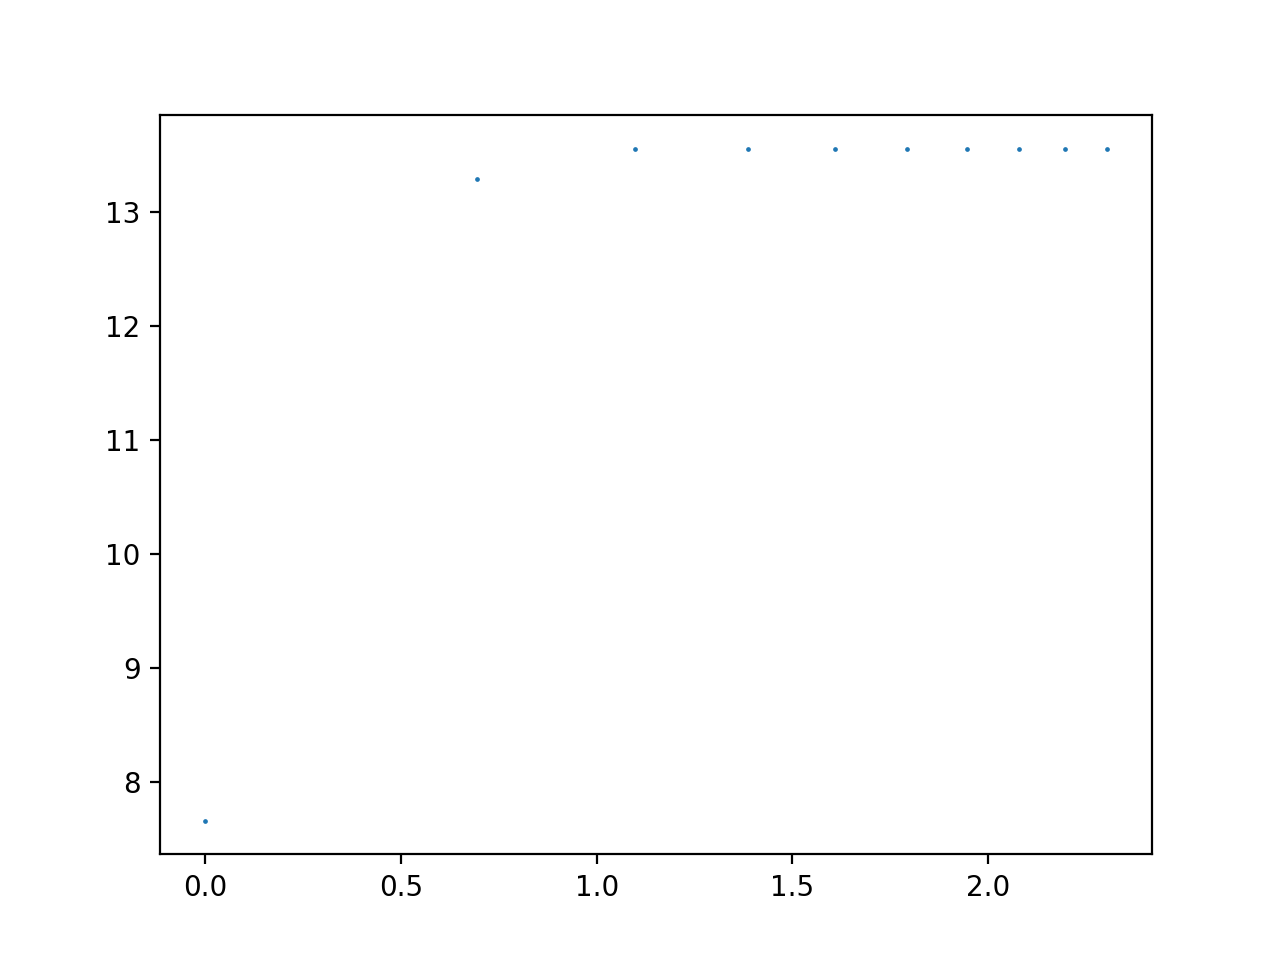

In [37]:
plot_log_log(np.asarray(zip(xs,ys)))

In [42]:
sample_size=1
random_idx = np.random.choice(xrange(len(node_neighbors.keys())),replace=False,size=sample_size)
#random_edges = np.random.choice(edge_weights.keys(),replace=False,size=sample_size) 
chosen_nodes = [node_neighbors.keys()[i] for i in random_idx] #randomly chosen seed nodes

seen_nodes = set()
new_nodes = set(chosen_nodes)
xs = []
ys= []

In [7]:
G

In [44]:
node_neighbors[4137995]

{43802}

In [45]:
comm_neighbors[43802]

{137360,
 179631,
 293995,
 294965,
 341276,
 396799,
 476393,
 480115,
 492290,
 539985,
 608250,
 660258,
 688478,
 690008,
 690315,
 690372,
 690595,
 720288,
 745098,
 770283,
 778307,
 797042,
 824133,
 861468,
 875677,
 891621,
 892073,
 933677,
 1046725,
 1107538,
 1130133,
 1130134,
 1130171,
 1130230,
 1130248,
 1130255,
 1132181,
 1172349,
 1178319,
 1178374,
 1196097,
 1206891,
 1207091,
 1207175,
 1238353,
 1265424,
 1267600,
 1270399,
 1273097,
 1275266,
 1383572,
 1386996,
 1408045,
 1408047,
 1411525,
 1411546,
 1411771,
 1411819,
 1412211,
 1412213,
 1416556,
 1426627,
 1481472,
 1575762,
 1583192,
 1583193,
 1620366,
 1631926,
 1631998,
 1694578,
 1717514,
 1724785,
 1745477,
 1764155,
 1766200,
 1766470,
 1795597,
 1807488,
 1867975,
 1868110,
 1868116,
 1894035,
 1926370,
 1927521,
 1947663,
 2117582,
 2120554,
 2121320,
 2156269,
 2192643,
 2226358,
 2226396,
 2226427,
 2226485,
 2231008,
 2231311,
 2232137,
 2250625,
 2250696,
 2251866,
 2255039,
 2265850,
 2266479